In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import DenseNet121
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Path of dataset
TRAIN_PATH = '/content/drive/MyDrive/Dataset/BanglaCurrency/Training'

In [4]:
takas = os.listdir(TRAIN_PATH)
takas = takas[0:]
print(takas)

['10', '1', '100', '500', '1000', '20', '5', '200', '2', '50']


In [5]:
# Data Preprocessing
image_size = (250, 120)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1697 files belonging to 10 classes.
Using 1358 files for training.
Found 1697 files belonging to 10 classes.
Using 339 files for validation.


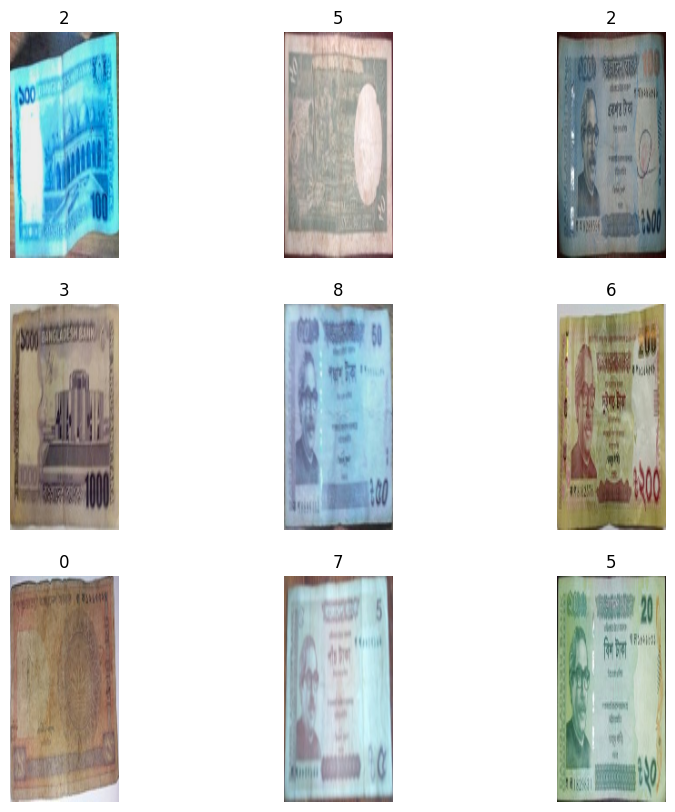

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

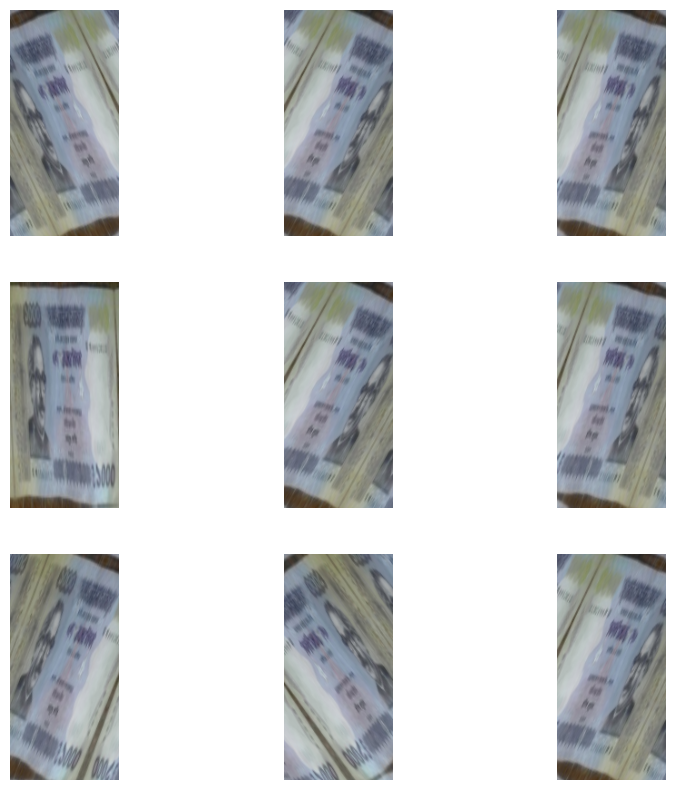

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
# Load DenseNet Model
IMAGE_SIZE = [250, 120]
densenet = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in densenet.layers:
    layer.trainable = False

x = Flatten()(densenet.output)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=densenet.input, outputs=x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 250, 120, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 256, 126, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 125, 60, 64)    │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 125, 60, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 125, 60, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 127, 62, 64)    │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 63, 30, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 63, 30, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 63, 30, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 63, 30, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 63, 30, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 63, 30, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 63, 30, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 63, 30, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,252,554 (27.67 MB)

 Trainable params: 215,050 (840.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [15]:
# Train Model
epochs = 10
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 464s 41s/step - accuracy: 0.1707 - loss: 25.6293 - val_accuracy: 0.2330 - val_loss: 19.5136
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 261s 19s/step - accuracy: 0.2705 - loss: 16.1651 - val_accuracy: 0.5074 - val_loss: 12.2818
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 241s 22s/step - accuracy: 0.5215 - loss: 7.6523 - val_accuracy: 0.6608 - val_loss: 4.4473
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 228s 19s/step - accuracy: 0.6332 - loss: 3.3659 - val_accuracy: 0.6903 - val_loss: 2.9426
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 203s 18s/step - accuracy: 0.7323 - loss: 2.1901 - val_accuracy: 0.7316 - val_loss: 2.0477
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 208s 19s/step - accuracy: 0.7689 - loss: 1.3509 - val_accuracy: 0.7611 - val_loss: 1.7127
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 204s 18s/step - accuracy: 0.7699 - loss: 1.2355 - val_accuracy: 0.7699 - val_loss: 1.2329
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 204s 18s/step - accuracy: 0.7986 - loss: 1.0187 - val_accuracy

In [16]:
# Save Model
model.save("/content/drive/MyDrive/dataset/saved_model/currency_recognition_model(denseNet).h5")

In [17]:
# Evaluate Model
y_true = []
y_pred = []
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step


In [18]:
# Performance Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.66      0.98      0.79        42
           2       0.90      0.89      0.90        53
           3       0.91      0.86      0.88        35
           4       1.00      0.78      0.88        37
           5       0.81      0.69      0.75        32
           6       1.00      1.00      1.00        13
           7       0.93      0.63      0.75        43
           8       0.58      0.78      0.67        37
           9       0.59      0.65      0.62        31

    accuracy                           0.79       339
   macro avg       0.84      0.79      0.80       339
weighted avg       0.82      0.79      0.79       339

Confusion Matrix:
[[10  2  0  0  0  1  0  1  1  1]
 [ 0 41  1  0  0  0  0  0  0  0]
 [ 0  0 47  1  0  0  0  0  0  5]
 [ 0  3  0 30  0  0  0  0  2  0]
 [ 0  1  1  0 29  2  0  0  4  0]
 [ 0  0  1  0  0 22  0  0  5  4]
 [

In [19]:
# Testing with a Sample Image
currency = ["1", "10", "100", "1000", "2", "20", "200", "5", "50", "500"]
img_path = "/content/drive/MyDrive/Dataset/BanglaCurrency/Testing/0.jpg"
img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print("Predicted Currency:", currency[predictions.argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Currency: 100


In [20]:
# Audio Feedback
from IPython.display import Audio
audio_files = {
    "1": "one.mp3", "2": "two.mp3", "5": "five.mp3", "10": "ten.mp3",
    "20": "twenty.mp3", "50": "fifty.mp3", "100": "onehundred.mp3",
    "200": "twohundred.mp3", "500": "fivehundred.mp3", "1000": "thousand.mp3"
}
if currency[predictions.argmax()] in audio_files:
    wn = Audio(f'/content/drive/MyDrive/Dataset/BanglaCurrency/Voice/{audio_files[currency[predictions.argmax()]]}', autoplay=True)
    display(wn)
else:
    print("Something went wrong!")